In [1]:
import torch
import torchvision
import numpy as np
import random

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data'

train_data = torchvision.datasets.MNIST(root=ROOT, train=True, download=True)

C:\Users\Tyrone\anaconda3\envs\pytorch-course\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
mean = train_data.data.float().mean() / 225
std = train_data.data.float().std() / 225

print(f'data mean: {mean}')
print(f'data std: {std}')

data mean: 0.14808188378810883
data std: 0.34918883442878723


In [5]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0, )),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [6]:
train_data = torchvision.datasets.MNIST(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.MNIST(root=ROOT,
                                       train=False,
                                       download=True,
                                       transform=test_transforms)

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [8]:
import matplotlib.pyplot as plt

def plot_images(images):
    n_images = len(images)
    rows = cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

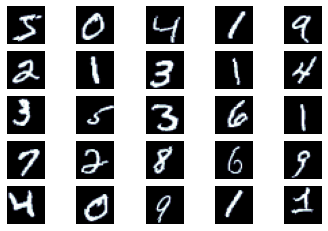

In [9]:
N_IMAGES = 25

# images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
images = [train_data[i][0] for i in range(N_IMAGES)]

plot_images(images)

In [10]:
VALID_RATIO = 0.1

n_train_examples = int(len(train_data) * (1 - VALID_RATIO))
n_test_examples = int(len(train_data) * VALID_RATIO)

In [11]:
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_test_examples])

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [13]:
import copy

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 256

train_iterator = DataLoader(train_data, BATCH_SIZE, True)
valid_iterator = DataLoader(valid_data, BATCH_SIZE, False)
test_iterator = DataLoader(test_data, BATCH_SIZE, False)

In [15]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_1 = nn.Linear(784, 250)
        self.fc_2 = nn.Linear(250, 100)
        self.fc_3 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
    
    def forward(self, batch):
        batch_size = batch.shape[0]

        batch = batch.view(batch_size, -1)

        h_1 = self.relu(self.fc_1(batch))
        h_2 = self.relu(self.fc_2(h_1))
        
        preds = self.fc_3(h_2)

        return preds, h_2

In [16]:
model = MLP()

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

222360

In [18]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [20]:
def calculate_accuracy(preds, labels):
    top_preds = torch.argmax(preds, dim=1, keepdim=True)
    correct = top_preds.eq(labels.view_as(top_preds)).sum()
    acc = correct.float() / labels.shape[0]

    return acc

In [21]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for images, labels in iterator:
        images, labels = images.to(device), labels.to(device)

        preds, _ = model(images)

        loss = criterion(preds, labels)
        acc = calculate_accuracy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for images, labels in iterator:
            images, labels = images.to(device), labels.to(device)

            preds, _ = model(images)

            loss = criterion(preds, labels)
            acc = calculate_accuracy(preds, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [23]:
N_EPOCH = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCH):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, train_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model')
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train Loss: 0.647 | Train Acc: 80.02%
	 Val. Loss: 0.291 |  Val. Acc: 91.42%
Epoch: 02
	Train Loss: 0.236 | Train Acc: 93.11%
	 Val. Loss: 0.187 |  Val. Acc: 94.26%
Epoch: 03
	Train Loss: 0.172 | Train Acc: 94.81%
	 Val. Loss: 0.152 |  Val. Acc: 95.38%
Epoch: 04
	Train Loss: 0.142 | Train Acc: 95.63%
	 Val. Loss: 0.132 |  Val. Acc: 95.88%
Epoch: 05
	Train Loss: 0.121 | Train Acc: 96.33%
	 Val. Loss: 0.105 |  Val. Acc: 96.76%
Epoch: 06
	Train Loss: 0.109 | Train Acc: 96.55%
	 Val. Loss: 0.102 |  Val. Acc: 96.87%
Epoch: 07
	Train Loss: 0.099 | Train Acc: 96.92%
	 Val. Loss: 0.097 |  Val. Acc: 96.94%
Epoch: 08
	Train Loss: 0.099 | Train Acc: 96.93%
	 Val. Loss: 0.088 |  Val. Acc: 97.28%
Epoch: 09
	Train Loss: 0.091 | Train Acc: 97.13%
	 Val. Loss: 0.082 |  Val. Acc: 97.39%
Epoch: 10
	Train Loss: 0.083 | Train Acc: 97.47%
	 Val. Loss: 0.078 |  Val. Acc: 97.54%


In [24]:
model.load_state_dict(torch.load('mlp-model'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

	 Test Loss: 0.057 |  Test Acc: 98.18%
